<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [ ]:
# Installation
!pip install yfinance
!pip install yahoo_fin --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random

## Hyper parameters
history = "5y"
buy_trigger = 3                           # times standard deviation
sell_trigger = 1                          # times the avg cost of the security to grow before we sell
security_age = 15                         # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000                # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"                         # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5                     # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 100                   # number of backtests to run
backtest_days = random.sample(range(100, 400), backtest_iterations) # starting days for back testing
backtest_days.sort()
prefer_beta = True

starting_balance = 10000                  # seed money to start investing
current_account = original_balance = starting_balance
portfolio = {}

# Display test results
print_final_portfolio = False              # Prints the portfolio list at the end of each backtest iteration
plot_every_test_graph = True              # Prints the model performance during the back end against s&P500
plot_summary_graph = True                  # prints the summary graph

In [ ]:
tests = [
    {
        "Name": "Test 1",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1000,
        "prefer_beta": True
     },
     {
        "Name": "Test 2",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
     {
        "Name": "Test 3",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
     {
        "Name": "Test 4",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False
     },
     {
        "Name": "Test 5",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True
     },
]

tests_to_run = [5]

In [ ]:
import yfinance as yahooFinance
import yahoo_fin.stock_info as si
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=4)

stocks = si.tickers_sp500()
indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

betas = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/betas.csv")
betas = betas.drop(['index', 'Attribute', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
betas = betas.rename(columns={"Recent": "Beta"})
betas = betas.set_index('Ticker')
for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock] = (d['Close'] - d['Open']) * 100/d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()


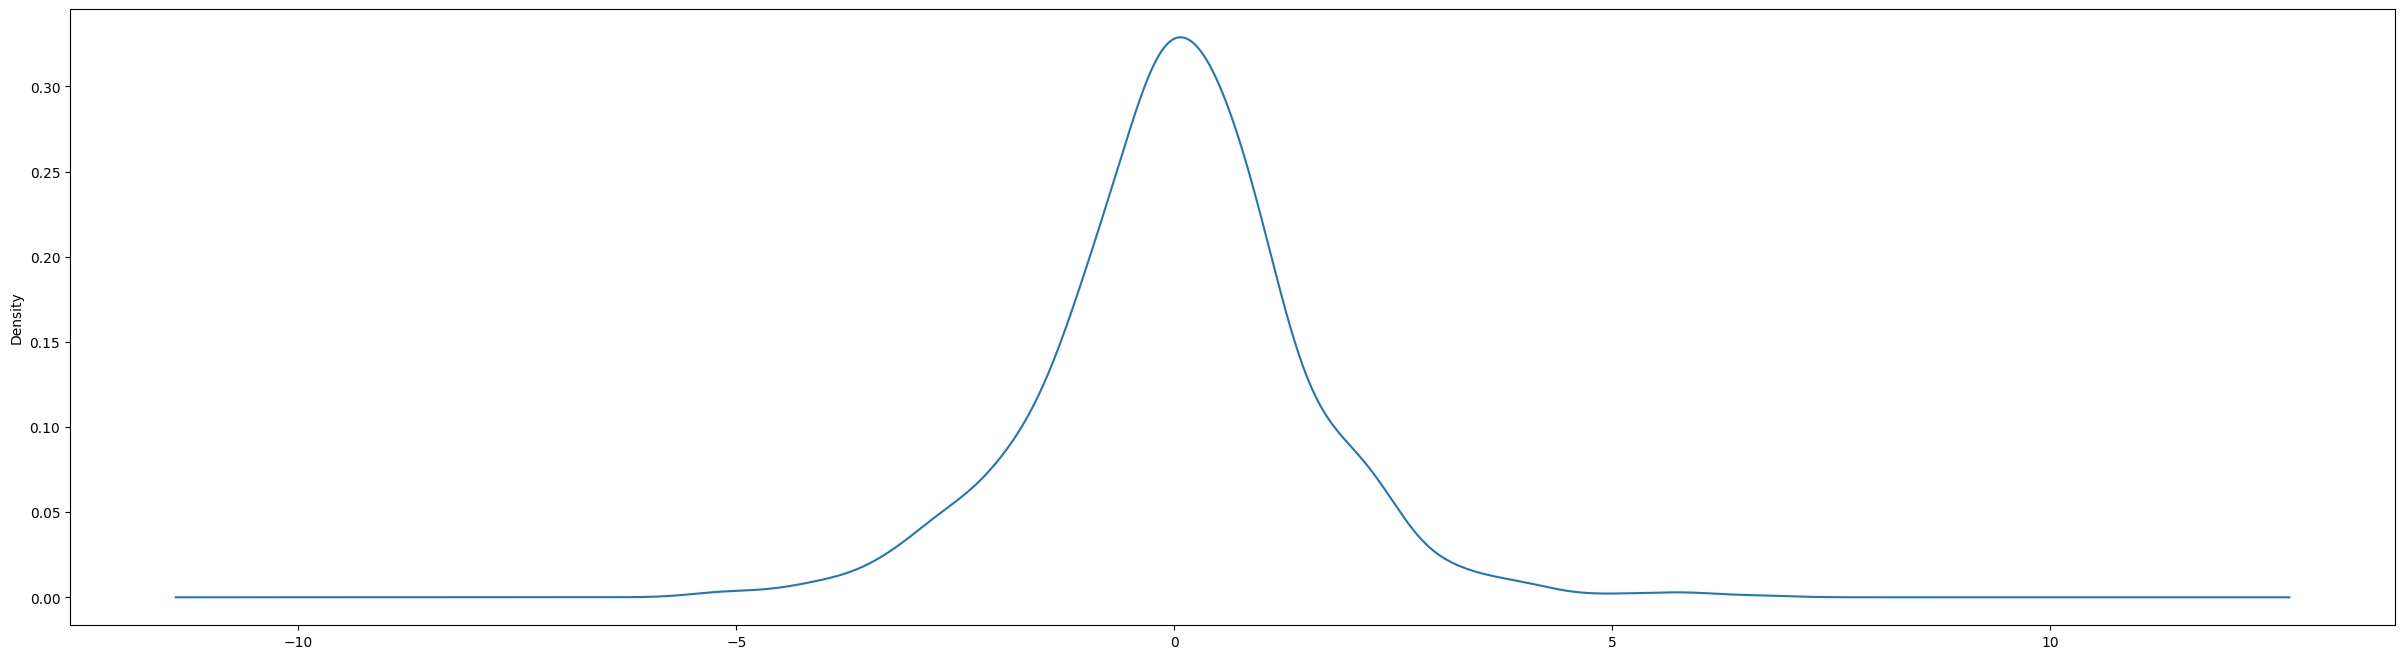

In [ ]:

for stock in stocks[:1]:
    #latest[stock] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']

    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock, title="Stocks Daily Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock, data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();

In [ ]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title="Daily Stock Price change", markers=True)
fig.show()


In [ ]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s] = (stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"])* 100 /stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean_type != "+ve" or mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)
  latest_diff['beta'] = betas['Beta']

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s] * avg / 100 <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s, 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s, 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  sell_stocks = latest_diff[latest_diff['sell']]
  buy_stocks = latest_diff[latest_diff['buy']]
  if prefer_beta:
    buy_stocks = buy_stocks.sort_values('beta',ascending=False)
  return sell_stocks, buy_stocks


In [ ]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = starting_balance
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  cash_inhand = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. Beta
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(max_stocks_to_buy):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      cash_inhand.append(current_account)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement, cash_inhand

In [ ]:

def run_backtest():
  nws = {}
  sp_ret = {}
  for i in backtest_days:
    tradingdays_togoback = i
    networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
    # normalize s&p500 for starting balance
    idx_list = list(indices_ts.loc[indices_ts.index[-tradingdays_togoback:], "^GSPC_Close"] * starting_balance/indices_ts.loc[indices_ts.index[-tradingdays_togoback], "^GSPC_Close"])
    pm_pct = (pm[-1]-pm[0])*100/pm[0]
    d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
    d.index = indices_ts.index[-tradingdays_togoback:]
    idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
    print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
    print("Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct))
    if print_final_portfolio:
      pp.pprint(portfolio)
    nws[i] = networth
    sp_ret[i] = idx_list[-1]
    if plot_every_test_graph:
      fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
      fig.show()

  if plot_summary_graph:
    plt.plot(nws.keys(), nws.values(), color="green", label='Model')
    plt.plot(sp_ret.keys(), sp_ret.values(), color="blue", label='S&P 500')
    plt.title("Networth at the end of each iteration")
    plt.xlabel('Days') 
    plt.ylabel('Networth')
    plt.legend()
    plt.show()
    print(sum(nws.values())/len(nws))

In [ ]:

for i in tests_to_run:
  t = tests[i-1]
  buy_trigger = t['buy_trigger']    # times standard deviation
  sell_trigger = t['sell_trigger']   # times the avg cost of the security to grow before we sell
  security_age = t['security_age']  # number of days to hold the security before we cut the losses
  lockin_gains_factor = t['lockin_gains_factor'] # times the orignal amount to grow before we lockin the gains.
  prefer_beta = t['prefer_beta']
  print("Test Parameters for " + t['Name'])
  print("=================================")
  pp.pprint(t)
  run_backtest()
  print()
  print("==================================\n")

Test Parameters for Test 5
{   'Name': 'Test 5',
    'buy_trigger': 2,
    'lockin_gains_factor': 1.1,
    'prefer_beta': True,
    'security_age': 90,
    'sell_trigger': 1}
Total networth: 11647 (Cash 1013) after going back 109
Model (16.479247)% vs S&P Performance (6.483359)%


Total networth: 11717 (Cash 1183) after going back 115
Model (17.174376)% vs S&P Performance (11.728276)%


Total networth: 12584 (Cash 2428) after going back 117
Model (25.849490)% vs S&P Performance (11.973050)%


Total networth: 12561 (Cash 3283) after going back 121
Model (25.618527)% vs S&P Performance (12.903682)%


Total networth: 12579 (Cash 2422) after going back 126
Model (25.790155)% vs S&P Performance (14.605282)%


Total networth: 12510 (Cash 2454) after going back 128
Model (25.103785)% vs S&P Performance (10.493838)%


Total networth: 12791 (Cash 2355) after going back 129
Model (27.911737)% vs S&P Performance (12.667488)%


Total networth: 12509 (Cash 2453) after going back 133
Model (25.094115)% vs S&P Performance (8.427072)%


Total networth: 12507 (Cash 2451) after going back 134
Model (25.075606)% vs S&P Performance (6.571181)%


Total networth: 12483 (Cash 4373) after going back 135
Model (24.834777)% vs S&P Performance (5.369899)%


Total networth: 10072 (Cash 218) after going back 142
Model (0.721979)% vs S&P Performance (2.574276)%


Total networth: 11075 (Cash 969) after going back 145
Model (10.755249)% vs S&P Performance (4.715540)%


Total networth: 11058 (Cash 2683) after going back 150
Model (10.589737)% vs S&P Performance (1.272905)%


Total networth: 11117 (Cash 1104) after going back 151
Model (11.174228)% vs S&P Performance (-2.138783)%


Total networth: 10149 (Cash 210) after going back 154
Model (1.498155)% vs S&P Performance (-0.693094)%


Total networth: 10937 (Cash 1167) after going back 157
Model (9.377659)% vs S&P Performance (-3.854198)%


Total networth: 10937 (Cash 1167) after going back 160
Model (9.377659)% vs S&P Performance (-3.991445)%


Total networth: 11071 (Cash 1230) after going back 163
Model (10.715043)% vs S&P Performance (-0.319230)%


Total networth: 11034 (Cash 965) after going back 167
Model (10.343112)% vs S&P Performance (-1.103682)%


Total networth: 11333 (Cash 2605) after going back 170
Model (13.336437)% vs S&P Performance (-0.507954)%


Total networth: 11078 (Cash 1237) after going back 171
Model (10.786766)% vs S&P Performance (0.905605)%


Total networth: 11288 (Cash 169) after going back 173
Model (12.881558)% vs S&P Performance (4.801265)%


Total networth: 11286 (Cash 48) after going back 174
Model (12.860995)% vs S&P Performance (3.591523)%


Total networth: 11614 (Cash 880) after going back 179
Model (16.143796)% vs S&P Performance (7.268882)%


Total networth: 12491 (Cash 4380) after going back 180
Model (24.910108)% vs S&P Performance (6.371731)%


Total networth: 12479 (Cash 4368) after going back 182
Model (24.792691)% vs S&P Performance (8.089106)%


Total networth: 11774 (Cash 780) after going back 184
Model (17.749689)% vs S&P Performance (6.612654)%


Total networth: 12402 (Cash 2667) after going back 190
Model (24.027747)% vs S&P Performance (8.557402)%


Total networth: 12463 (Cash 2585) after going back 193
Model (24.636937)% vs S&P Performance (5.363950)%


Total networth: 12463 (Cash 2585) after going back 194
Model (24.636937)% vs S&P Performance (5.050695)%


Total networth: 12568 (Cash 1111) after going back 196
Model (25.683427)% vs S&P Performance (9.293362)%


Total networth: 12728 (Cash 4604) after going back 205
Model (27.288089)% vs S&P Performance (-0.156956)%


Total networth: 11637 (Cash 789) after going back 209
Model (16.374420)% vs S&P Performance (-1.616296)%


Total networth: 12606 (Cash 4605) after going back 210
Model (26.060621)% vs S&P Performance (0.197016)%


Total networth: 11055 (Cash 2679) after going back 211
Model (10.550713)% vs S&P Performance (-0.552735)%


Total networth: 11686 (Cash 862) after going back 215
Model (16.864244)% vs S&P Performance (4.258047)%


Total networth: 11701 (Cash 877) after going back 216
Model (17.013425)% vs S&P Performance (3.411389)%


Total networth: 13587 (Cash 4450) after going back 217
Model (35.878493)% vs S&P Performance (5.330191)%


Total networth: 12582 (Cash 4620) after going back 223
Model (25.821950)% vs S&P Performance (4.560466)%


Total networth: 12939 (Cash 882) after going back 226
Model (29.395643)% vs S&P Performance (2.958230)%


Total networth: 12409 (Cash 3417) after going back 233
Model (24.099955)% vs S&P Performance (-4.156034)%


Total networth: 11619 (Cash 886) after going back 235
Model (16.194921)% vs S&P Performance (-1.578131)%


Total networth: 11619 (Cash 886) after going back 236
Model (16.194921)% vs S&P Performance (-4.348343)%


Total networth: 11644 (Cash 964) after going back 241
Model (16.446985)% vs S&P Performance (-6.429868)%


Total networth: 11623 (Cash 959) after going back 243
Model (16.230054)% vs S&P Performance (-7.585134)%


Total networth: 11512 (Cash 4446) after going back 245
Model (15.126448)% vs S&P Performance (-6.871789)%


Total networth: 11804 (Cash 1194) after going back 249
Model (18.044921)% vs S&P Performance (-9.188929)%


Total networth: 11141 (Cash 2477) after going back 252
Model (11.414744)% vs S&P Performance (-9.294966)%


Total networth: 11020 (Cash 864) after going back 253
Model (10.206617)% vs S&P Performance (-10.714731)%


Total networth: 11058 (Cash 2682) after going back 256
Model (10.583465)% vs S&P Performance (-9.547530)%


Total networth: 12492 (Cash 4382) after going back 258
Model (24.927285)% vs S&P Performance (-7.785266)%


Total networth: 11139 (Cash 2475) after going back 262
Model (11.397573)% vs S&P Performance (-6.853637)%


Total networth: 11641 (Cash 960) after going back 266
Model (16.414340)% vs S&P Performance (-2.259586)%


Total networth: 12401 (Cash 3409) after going back 271
Model (24.018615)% vs S&P Performance (-5.071995)%


Total networth: 11006 (Cash 849) after going back 272
Model (10.062917)% vs S&P Performance (-5.825157)%


Total networth: 11395 (Cash 2437) after going back 273
Model (13.959153)% vs S&P Performance (-6.320015)%


Total networth: 11295 (Cash 57) after going back 274
Model (12.956338)% vs S&P Performance (-4.573568)%


Total networth: 11714 (Cash 1180) after going back 275
Model (17.149271)% vs S&P Performance (-6.050149)%


Total networth: 11714 (Cash 1180) after going back 276
Model (17.149271)% vs S&P Performance (-6.279631)%


Total networth: 12415 (Cash 4279) after going back 277
Model (24.156368)% vs S&P Performance (-4.182856)%


Total networth: 11463 (Cash 199) after going back 282
Model (14.632830)% vs S&P Performance (-8.172043)%


Total networth: 10260 (Cash 1057) after going back 287
Model (2.601015)% vs S&P Performance (-10.417514)%


Total networth: 11291 (Cash 53) after going back 291
Model (12.912179)% vs S&P Performance (-8.221883)%


Total networth: 11505 (Cash 4582) after going back 292
Model (15.057754)% vs S&P Performance (-10.460451)%


Total networth: 11116 (Cash 1103) after going back 295
Model (11.164652)% vs S&P Performance (-7.277774)%


Total networth: 11052 (Cash 861) after going back 296
Model (10.524768)% vs S&P Performance (-5.020206)%


Total networth: 12467 (Cash 4357) after going back 298
Model (24.679259)% vs S&P Performance (-5.672971)%


Total networth: 11238 (Cash 291) after going back 300
Model (12.385451)% vs S&P Performance (-6.562843)%


Total networth: 11082 (Cash 1070) after going back 301
Model (10.828119)% vs S&P Performance (-8.330190)%


Total networth: 9506 (Cash 159) after going back 302
Model (-4.933789)% vs S&P Performance (-9.341984)%


Total networth: 10376 (Cash 753) after going back 306
Model (3.764311)% vs S&P Performance (-13.055318)%


Total networth: 11603 (Cash 669) after going back 310
Model (16.033036)% vs S&P Performance (-12.494325)%


Total networth: 9008 (Cash 235) after going back 311
Model (-9.916312)% vs S&P Performance (-12.578661)%


Total networth: 11012 (Cash 855) after going back 316
Model (10.120547)% vs S&P Performance (-14.265417)%


Total networth: 11326 (Cash 2598) after going back 320
Model (13.267566)% vs S&P Performance (-12.503832)%


Total networth: 13868 (Cash 4439) after going back 330
Model (38.680212)% vs S&P Performance (-12.590374)%


Total networth: 10904 (Cash 1018) after going back 332
Model (9.046343)% vs S&P Performance (-10.505108)%


Total networth: 11692 (Cash 990) after going back 334
Model (16.920273)% vs S&P Performance (-10.220227)%


Total networth: 11142 (Cash 2663) after going back 337
Model (11.420648)% vs S&P Performance (-11.727783)%


Total networth: 11203 (Cash 337) after going back 338
Model (12.039492)% vs S&P Performance (-10.562572)%


Total networth: 12104 (Cash 1101) after going back 340
Model (21.041082)% vs S&P Performance (-12.394528)%


Total networth: 11335 (Cash 183) after going back 345
Model (13.352082)% vs S&P Performance (-12.584608)%


Total networth: 12497 (Cash 4332) after going back 349
Model (24.978745)% vs S&P Performance (-11.565170)%


Total networth: 13448 (Cash 2612) after going back 350
Model (34.481016)% vs S&P Performance (-12.292619)%


Total networth: 10260 (Cash 1027) after going back 354
Model (2.602134)% vs S&P Performance (-11.828162)%


Total networth: 11140 (Cash 2661) after going back 357
Model (11.404954)% vs S&P Performance (-10.771529)%


Total networth: 12534 (Cash 4369) after going back 359
Model (25.346278)% vs S&P Performance (-9.718831)%


Total networth: 13117 (Cash 2465) after going back 365
Model (31.175766)% vs S&P Performance (-9.078616)%


Total networth: 13117 (Cash 2465) after going back 366
Model (31.175766)% vs S&P Performance (-8.406403)%


Total networth: 13611 (Cash 3562) after going back 369
Model (36.114120)% vs S&P Performance (-5.831838)%


Total networth: 12346 (Cash 983) after going back 371
Model (23.461990)% vs S&P Performance (-5.775485)%


Total networth: 12924 (Cash 1180) after going back 372
Model (29.248112)% vs S&P Performance (-6.422409)%


Total networth: 13121 (Cash 2355) after going back 377
Model (31.214335)% vs S&P Performance (-5.685740)%


Total networth: 12651 (Cash 967) after going back 385
Model (26.519033)% vs S&P Performance (-5.624006)%


Total networth: 12651 (Cash 966) after going back 387
Model (26.513827)% vs S&P Performance (-7.301622)%


Total networth: 11347 (Cash 979) after going back 390
Model (13.472151)% vs S&P Performance (-7.511501)%


Total networth: 11350 (Cash 982) after going back 394
Model (13.500945)% vs S&P Performance (-8.966626)%
